# 12 Month EPS Growth Regression Model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Manipulate to get proper monthly EPS growth

Use monthly average PE ratio, average monthly prices, and the 10-Year Treasury Yield to calculate the proper EPS growth

In [19]:
pe_df = pd.read_csv('PE_daily_normalized.csv')

In [20]:
# rename and convert proper types
pe_df = pe_df.rename(columns={"Dates": "Date"})
pe_df['Date']= pd.to_datetime(pe_df['Date'])
pe_df.dtypes

Date    datetime64[ns]
PE             float64
dtype: object

In [23]:
pe_df.dtypes

Year       int64
Month      int64
PE       float64
dtype: object

In [22]:
pe_df = pe_df.set_index('Date')
# get average per year, month
pe_df = pe_df.groupby([(pe_df.index.year), (pe_df.index.month)]).PE.mean()
# convert to data frame
pe_df = pd.DataFrame(pe_df)
# rename, reset index
pe_df.index.names=['Year', 'Month']
pe_df =pe_df.reset_index()

In [24]:
pe_df.head(5)

,Year,Month,PE
0,2001,8,19.251125
1,2001,9,17.427800
2,2001,10,18.265739
3,2001,11,20.247286
4,2001,12,20.904150


Load monthly earnings prices

In [25]:
# load average monthly price
avg_m_price = pd.read_csv('avg_m_price.csv')
# convert proper types
avg_m_price['Dates']= pd.to_datetime(avg_m_price['Dates'])
# check for types
avg_m_price.dtypes

Dates    datetime64[ns]
Value           float64
dtype: object

In [26]:
avg_m_price = avg_m_price.set_index('Dates')
# get average per year, month
avg_m_price = avg_m_price.groupby([(avg_m_price.index.year), (avg_m_price.index.month)]).Value.mean()
# convert to data frame
avg_m_price = pd.DataFrame(avg_m_price)
# rename, reset index
avg_m_price.index.names=['Year', 'Month']
avg_m_price =avg_m_price.reset_index()
# convert proper type
avg_m_price['Month'] = avg_m_price['Month'].astype(int)

In [27]:
avg_m_price.head(5)

,Year,Month,Value
0,2001,8,368.566087
1,2001,9,323.474000
2,2001,10,332.585652
3,2001,11,348.135714
4,2001,12,350.799500


### Join pe and average earnings together

In [29]:
joined = pd.merge(pe_df, avg_m_price,  how='inner', left_on=['Year','Month'], right_on = ['Year', 'Month'])

# get monthly earnings by dividing the two
joined['m_earnings'] = joined['Value']/joined['PE']

# shift monthly earning for later's monthly earning 
joined['prev_m'] = joined['m_earnings'].shift(1)

# calculate monthly EPS growth without subtracting the 10 year yield
joined['EPS_growth'] = ((joined['m_earnings'] - joined['prev_m']) / joined['prev_m'] + 1.0)**12 - 1

In [30]:
joined.head(5)

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth
0,2001,8,19.251125,368.566087,19.145171,NaN,NaN
1,2001,9,17.427800,323.474000,18.560805,19.145171,-0.310633
2,2001,10,18.265739,332.585652,18.208168,18.560805,-0.205611
3,2001,11,20.247286,348.135714,17.194192,18.208168,-0.497211
4,2001,12,20.904150,350.799500,16.781333,17.194192,-0.252973


### Load 10-year treasury

In [31]:
treasury = pd.read_csv('mth_treasury_10yr.csv')

# offset by one day to match the proper month later
treasury['DATE'] = pd.to_datetime(treasury['DATE'])
treasury['DATE'] = pd.DatetimeIndex(treasury['DATE'] - pd.DateOffset(1))

# get separate year and month for joining later
treasury['Year'] = pd.DatetimeIndex(treasury.DATE).year
treasury['Month'] = pd.DatetimeIndex(treasury.DATE).month

# divide GS10 by 100 to convert to decimals
treasury['GS10'] = treasury['GS10']/100

In [33]:
treasury.head(5)

,DATE,GS10,Year,Month
0,1953-03-31,0.0283,1953,3
1,1953-04-30,0.0305,1953,4
2,1953-05-31,0.0311,1953,5
3,1953-06-30,0.0293,1953,6
4,1953-07-31,0.0295,1953,7


Join to calculate the final monthly eps growth

In [34]:
new_joined = pd.merge(joined, treasury,  how='inner', left_on=['Year','Month'], right_on = ['Year', 'Month'])

new_joined['final_EPS_growth'] = new_joined['EPS_growth'] - new_joined['GS10']

In [40]:
new_joined.head(5)

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth
0,2001,8,19.251125,368.566087,19.145171,NaN,NaN,2001-08-31,0.0473,NaN
1,2001,9,17.427800,323.474000,18.560805,19.145171,-0.310633,2001-09-30,0.0457,-0.356333
2,2001,10,18.265739,332.585652,18.208168,18.560805,-0.205611,2001-10-31,0.0465,-0.252111
3,2001,11,20.247286,348.135714,17.194192,18.208168,-0.497211,2001-11-30,0.0509,-0.548111
4,2001,12,20.904150,350.799500,16.781333,17.194192,-0.252973,2001-12-31,0.0504,-0.303373


In [36]:
# 132 positive growths out of the rest
new_joined[new_joined['final_EPS_growth'] > 0]

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth
5,2002,1,20.717238,354.028571,17.088599,16.781333,0.243254,2002-01-31,0.0491,0.194154
6,2002,2,19.548000,337.302632,17.255097,17.088599,0.123392,2002-02-28,0.0528,0.070592
9,2002,5,21.617136,357.665909,16.545481,16.287122,0.207871,2002-05-31,0.0493,0.158571
10,2002,6,20.353650,339.778500,16.693738,16.545481,0.112988,2002-06-30,0.0465,0.066488
11,2002,7,18.195636,306.088636,16.822090,16.693738,0.096267,2002-07-31,0.0426,0.053667
...,...,...,...,...,...,...,...,...,...,...
232,2020,12,19.598182,476.858182,24.331756,23.898429,0.240650,2020-12-31,0.0108,0.229850
233,2021,1,20.527947,504.580000,24.580149,24.331756,0.129621,2021-01-31,0.0126,0.117021
234,2021,2,20.969263,524.801579,25.027183,24.580149,0.241451,2021-02-28,0.0161,0.225351
235,2021,3,21.862250,563.589565,25.779120,25.027183,0.426506,2021-03-31,0.0164,0.410106


In [38]:
new_joined.dtypes

Year                         int64
Month                        int64
PE                         float64
Value                      float64
m_earnings                 float64
prev_m                     float64
EPS_growth                 float64
DATE                datetime64[ns]
GS10                       float64
final_EPS_growth           float64
dtype: object

<AxesSubplot:xlabel='DATE'>

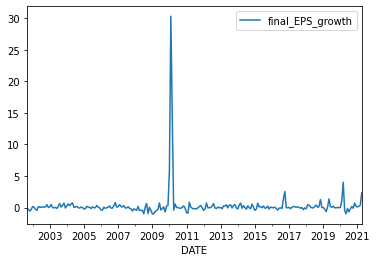

In [41]:
new_joined.loc[1:,['DATE','final_EPS_growth']].set_index('DATE').plot()

In [42]:
# make a copy
final_df = new_joined.copy()

Create placeholder columns for independent variables


In [43]:
final_df['fed'] = None
final_df['pmi'] = None
final_df['consumer'] = None
final_df['bci_data'] = None

Create placeholder columns for dependent variables, which are future 12-month EPS growth rate

In [44]:
final_df['EPS_1'] = None
final_df['EPS_2'] = None
final_df['EPS_3'] = None
final_df['EPS_4'] = None
final_df['EPS_5'] = None
final_df['EPS_6'] = None
final_df['EPS_7'] = None
final_df['EPS_8'] = None
final_df['EPS_9'] = None
final_df['EPS_10'] = None
final_df['EPS_11'] = None
final_df['EPS_12'] = None

In [45]:
# convert to proper types
final_df['EPS_1'] = final_df['EPS_1'].astype(float)
final_df['EPS_2'] = final_df['EPS_2'].astype(float)
final_df['EPS_3'] = final_df['EPS_3'].astype(float)
final_df['EPS_4'] = final_df['EPS_4'].astype(float)
final_df['EPS_5'] = final_df['EPS_5'].astype(float)
final_df['EPS_6'] = final_df['EPS_6'].astype(float)
final_df['EPS_7'] = final_df['EPS_7'].astype(float)
final_df['EPS_8'] = final_df['EPS_8'].astype(float)
final_df['EPS_9'] = final_df['EPS_9'].astype(float)
final_df['EPS_10'] = final_df['EPS_10'].astype(float)
final_df['EPS_11'] = final_df['EPS_11'].astype(float)
final_df['EPS_12'] = final_df['EPS_12'].astype(float)

final_df['fed'] = final_df['fed'].astype(float)
final_df['pmi'] = final_df['pmi'].astype(float)
final_df['consumer'] = final_df['consumer'].astype(float)
final_df['bci_data'] = final_df['bci_data'].astype(float)
final_df['final_EPS_growth'] = final_df['final_EPS_growth'].astype(float)

In [47]:
# fill the future 12 monthly eps growths
for index, row in final_df.iterrows():
    if row['DATE'] > pd.Timestamp(year=2020, month=4, day=30, hour=0):
        break
    i = 1
    for i2, row2 in final_df.iterrows():
        if row2['DATE'] > row['DATE']:
            col_name = 'EPS_' + str(i)
            final_df.at[index, col_name] = row2['final_EPS_growth']
            i+=1
            if(i > 12):
                break

In [48]:
final_df

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
0,2001,8,19.251125,368.566087,19.145171,NaN,NaN,2001-08-31,0.0473,NaN,...,-0.548111,-0.303373,0.194154,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109
1,2001,9,17.427800,323.474000,18.560805,19.145171,-0.310633,2001-09-30,0.0457,-0.356333,...,-0.303373,0.194154,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123
2,2001,10,18.265739,332.585652,18.208168,18.560805,-0.205611,2001-10-31,0.0465,-0.252111,...,0.194154,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123,0.126309
3,2001,11,20.247286,348.135714,17.194192,18.208168,-0.497211,2001-11-30,0.0509,-0.548111,...,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123,0.126309,0.463027
4,2001,12,20.904150,350.799500,16.781333,17.194192,-0.252973,2001-12-31,0.0504,-0.303373,...,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123,0.126309,0.463027,0.037245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2020,12,19.598182,476.858182,24.331756,23.898429,0.240650,2020-12-31,0.0108,0.229850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,2021,1,20.527947,504.580000,24.580149,24.331756,0.129621,2021-01-31,0.0126,0.117021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,2021,2,20.969263,524.801579,25.027183,24.580149,0.241451,2021-02-28,0.0161,0.225351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,2021,3,21.862250,563.589565,25.779120,25.027183,0.426506,2021-03-31,0.0164,0.410106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Load independ variables

In [49]:
import quandl
quandl.ApiConfig.api_key = 'AtPuHRXs-rLGozrAYSKk'

fed_funds_data = quandl.get("FRED/FEDFUNDS", collapse="monthly")

fed_funds_data = fed_funds_data[fed_funds_data.index >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

fed_funds_data

,Value
Date,
2001-09-30,3.07
2001-10-31,2.49
2001-11-30,2.09
2001-12-31,1.82
2002-01-31,1.73
...,...
2021-03-31,0.07
2021-04-30,0.07
2021-05-31,0.06


In [50]:
bci_data = pd.read_csv('BCI_data.csv')

bci_data['TIME'] = pd.to_datetime(bci_data['TIME'])

bci_data = bci_data[bci_data.TIME >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

bci_data

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
621,USA,BCI,AMPLITUD,LTRENDIDX,M,2001-10-01,97.84437,NaN
622,USA,BCI,AMPLITUD,LTRENDIDX,M,2001-11-01,97.99640,NaN
623,USA,BCI,AMPLITUD,LTRENDIDX,M,2001-12-01,98.46352,NaN
624,USA,BCI,AMPLITUD,LTRENDIDX,M,2002-01-01,99.11134,NaN
625,USA,BCI,AMPLITUD,LTRENDIDX,M,2002-02-01,99.78757,NaN
...,...,...,...,...,...,...,...,...
854,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-03-01,102.13000,NaN
855,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-04-01,102.03050,NaN
856,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-05-01,101.88540,NaN
857,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-06-01,101.70810,NaN


In [74]:
pmi_data = quandl.get("ISM/MAN_PMI", collapse="monthly")

pmi_data = pmi_data[pmi_data.index >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

pmi_data

,PMI
Date,
2001-09-30,46.2
2001-10-31,40.8
2001-11-30,44.1
2001-12-31,45.3
2002-01-31,47.5
...,...
2021-03-31,64.7
2021-04-30,60.7
2021-05-31,61.2


In [52]:
consumer_conf_data = quandl.get("BCB/4393", collapse="monthly")

consumer_conf_data = consumer_conf_data[consumer_conf_data.index >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

consumer_conf_data

,Value
Date,
2001-09-30,90.74
2001-10-31,80.65
2001-11-30,78.31
2001-12-31,86.28
2002-01-31,87.04
...,...
2021-03-31,112.90
2021-04-30,104.95
2021-05-31,105.90


Fill in the independent variables by:
- finding the fed/pmi/consumer/bci that is 1) earlier than the timestamp, and 2) second closest to the timestamp

In [54]:
final_df

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
0,2001,8,19.251125,368.566087,19.145171,NaN,NaN,2001-08-31,0.0473,NaN,...,-0.548111,-0.303373,0.194154,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109
1,2001,9,17.427800,323.474000,18.560805,19.145171,-0.310633,2001-09-30,0.0457,-0.356333,...,-0.303373,0.194154,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123
2,2001,10,18.265739,332.585652,18.208168,18.560805,-0.205611,2001-10-31,0.0465,-0.252111,...,0.194154,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123,0.126309
3,2001,11,20.247286,348.135714,17.194192,18.208168,-0.497211,2001-11-30,0.0509,-0.548111,...,0.070592,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123,0.126309,0.463027
4,2001,12,20.904150,350.799500,16.781333,17.194192,-0.252973,2001-12-31,0.0504,-0.303373,...,-0.254058,-0.424845,0.158571,0.066488,0.053667,0.143109,0.053123,0.126309,0.463027,0.037245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2020,12,19.598182,476.858182,24.331756,23.898429,0.240650,2020-12-31,0.0108,0.229850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,2021,1,20.527947,504.580000,24.580149,24.331756,0.129621,2021-01-31,0.0126,0.117021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,2021,2,20.969263,524.801579,25.027183,24.580149,0.241451,2021-02-28,0.0161,0.225351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,2021,3,21.862250,563.589565,25.779120,25.027183,0.426506,2021-03-31,0.0164,0.410106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Model Logic

**1. Multi-step regression**: Using four predictor variables to predict 12-month ahead EPS growth concurrently 

**2. Target Variable**: For each month, the following 12 month EPS growth data are presented in the same row.

**3. Independent Variables**: We are using information from the past to predict future EPS growth. The independent variables are lagged by one month due to delays in predictor announcement. 



In [75]:
for index, row in final_df.iterrows():
    one_lag = -1.0 #initialization with meaningless negative value
    for i2, row2 in fed_funds_data.iterrows():
        
        if i2 <= row['DATE']:
            final_df.at[index, 'fed'] = one_lag
            one_lag = row2['Value']
        else:
            break
            
for index, row in final_df.iterrows():
    one_lag = -1.0 
    for i2, row2 in pmi_data.iterrows():
        
        if i2 <= row['DATE']:
            final_df.at[index, 'pmi'] = one_lag
            one_lag = row2['PMI']
        else:
            break
            
for index, row in final_df.iterrows():
    one_lag = -1.0
    for i2, row2 in consumer_conf_data.iterrows():
        
        if i2 <= row['DATE']:
            final_df.at[index, 'consumer'] = one_lag
            one_lag = row2['Value']
        else:
            break

for index, row in final_df.iterrows():
    one_lag = -1.0
    for i2, row2 in bci_data.iterrows():
        
        if row2['TIME'] <= row['DATE']:
            final_df.at[index, 'bci_data'] = one_lag
            one_lag = row2['Value']
        else:
            break

In [76]:
final_df.tail(15)

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
210,2019,2,15.959632,434.775263,27.242187,27.792256,-0.213284,2019-02-28,0.0257,-0.238984,...,1.375488,0.164777,0.044673,0.239776,-0.020600,-0.035269,0.028447,-0.013122,0.036949,1.131927
211,2019,3,17.204571,433.292857,25.184752,27.242187,-0.610284,2019-03-31,0.0253,-0.635584,...,0.164777,0.044673,0.239776,-0.020600,-0.035269,0.028447,-0.013122,0.036949,1.131927,4.012515
212,2019,4,17.711476,448.856667,25.342702,25.184752,0.077911,2019-04-30,0.0240,0.053911,...,0.044673,0.239776,-0.020600,-0.035269,0.028447,-0.013122,0.036949,1.131927,4.012515,-0.429637
213,2019,5,16.453227,448.467273,27.257101,25.342702,1.396188,2019-05-31,0.0207,1.375488,...,0.239776,-0.020600,-0.035269,0.028447,-0.013122,0.036949,1.131927,4.012515,-0.429637,-0.964101
214,2019,6,16.266200,449.697500,27.646131,27.257101,0.185377,2019-06-30,0.0206,0.164777,...,-0.020600,-0.035269,0.028447,-0.013122,0.036949,1.131927,4.012515,-0.429637,-0.964101,-0.131991
215,2019,7,16.833864,467.692273,27.782824,27.646131,0.060973,2019-07-31,0.0163,0.044673,...,-0.035269,0.028447,-0.013122,0.036949,1.131927,4.012515,-0.429637,-0.964101,-0.131991,-0.668883
216,2019,8,15.634000,442.708636,28.317042,27.782824,0.256776,2019-08-31,0.0170,0.239776,...,0.028447,-0.013122,0.036949,1.131927,4.012515,-0.429637,-0.964101,-0.131991,-0.668883,-0.205041
217,2019,9,16.365000,463.273000,28.308769,28.317042,-0.003500,2019-09-30,0.0171,-0.020600,...,-0.013122,0.036949,1.131927,4.012515,-0.429637,-0.964101,-0.131991,-0.668883,-0.205041,0.185201
218,2019,10,16.405478,463.749130,28.267943,28.308769,-0.017169,2019-10-31,0.0181,-0.035269,...,0.036949,1.131927,4.012515,-0.429637,-0.964101,-0.131991,-0.668883,-0.205041,0.185201,-0.090148
219,2019,11,17.381350,493.221000,28.376449,28.267943,0.047047,2019-11-30,0.0186,0.028447,...,1.131927,4.012515,-0.429637,-0.964101,-0.131991,-0.668883,-0.205041,0.185201,-0.090148,0.725569


In [57]:
len(final_df)

237

In [60]:
# remove the useless last twelve rows because they have no values yet
final_df = final_df.iloc[0:225]

In [79]:
final_df.tail()

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
220,2019,12,17.804450,505.415238,28.387018,28.376449,0.004478,2019-12-31,0.0176,-0.013122,...,4.012515,-0.429637,-0.964101,-0.131991,-0.668883,-0.205041,0.185201,-0.090148,0.725569,0.229850
221,2020,1,17.841286,508.602857,28.507074,28.387018,0.051949,2020-01-31,0.0150,0.036949,...,-0.429637,-0.964101,-0.131991,-0.668883,-0.205041,0.185201,-0.090148,0.725569,0.229850,0.117021
222,2020,2,16.480895,500.585789,30.373702,28.507074,1.140627,2020-02-29,0.0087,1.131927,...,-0.964101,-0.131991,-0.668883,-0.205041,0.185201,-0.090148,0.725569,0.229850,0.117021,0.225351
223,2020,3,10.600227,368.297273,34.744281,30.373702,4.019115,2020-03-31,0.0066,4.012515,...,-0.131991,-0.668883,-0.205041,0.185201,-0.090148,0.725569,0.229850,0.117021,0.225351,0.410106
224,2020,4,10.894238,361.561429,33.188317,34.744281,-0.422937,2020-04-30,0.0067,-0.429637,...,-0.668883,-0.205041,0.185201,-0.090148,0.725569,0.229850,0.117021,0.225351,0.410106,2.347552


### Modeling regression to predict future 12 monthly EPS growths based on various independent variables

In [82]:
train_X = final_df.iloc[3:201,10:14]
train_y = final_df.iloc[3:201,14::]

In [83]:
train_X

,fed,pmi,consumer,bci_data
3,2.49,40.8,80.65,97.84437
4,2.09,44.1,78.31,97.99640
5,1.82,45.3,86.28,98.46352
6,1.73,47.5,87.04,99.11134
7,1.74,50.7,90.66,99.78757
...,...,...,...,...
196,1.16,58.2,103.96,101.36940
197,1.30,59.3,109.46,101.43200
198,1.41,59.1,116.96,101.48510
199,1.42,60.7,120.57,101.51060


<b> Test on the last 24 months </b>

In [84]:
test_X = final_df.iloc[201::,10:14]
test_y = final_df.iloc[201::,14::]

In [85]:
test_X

,fed,pmi,consumer,bci_data
201,1.69,57.9,109.94,101.25080
202,1.70,58.7,113.50,101.29860
203,1.82,60.0,104.00,101.41680
204,1.91,58.4,103.48,101.48040
205,1.91,60.8,104.38,101.58630
206,1.95,59.5,106.79,101.49290
207,2.19,57.5,107.91,101.27140
208,2.20,58.8,114.50,101.04450
209,2.27,54.3,127.80,100.71080
210,2.40,56.6,128.64,100.55030


In [86]:
# linear regression for multioutput regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
# fit model
linear_regression.fit(train_X, train_y)

LinearRegression()

In [87]:
yhat = linear_regression.predict(test_X)
# summarize prediction

In [88]:
from sklearn.metrics import mean_absolute_error
print("Linear Regression MAE")
mean_absolute_error(test_y, yhat)

Linear Regression MAE


0.7693576635696706

In [89]:
# k-nearest neighbors for multioutput regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor

k_n_regressor = KNeighborsRegressor()
# fit model
k_n_regressor.fit(train_X, train_y)

KNeighborsRegressor()

In [90]:
yhat = k_n_regressor.predict(test_X)
# summarize prediction

In [91]:
from sklearn.metrics import mean_absolute_error
print("K Neighbor MAE")
mean_absolute_error(test_y, yhat)

K Neighbor MAE


0.5549639675613857

In [92]:
# decision tree for multioutput regression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor()
# fit model
tree_regressor.fit(train_X, train_y)

DecisionTreeRegressor()

In [93]:
yhat = tree_regressor.predict(test_X)
# summarize prediction

In [94]:
print("Decision Tree MAE")
mean_absolute_error(test_y, yhat)

Decision Tree MAE


0.6507061043519359

### Visualize prediction quality

In [95]:
test_data = final_df.iloc[201::]

In [96]:
test_data.head(5)

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
201,2018,5,19.136600,460.454545,24.061461,24.073735,-0.006102,2018-05-31,0.0291,-0.035202,...,0.407470,0.041651,0.176629,1.274986,0.011161,0.032432,-0.238984,-0.635584,0.053911,1.375488
202,2018,6,18.885450,453.979524,24.038587,24.061461,-0.011348,2018-06-30,0.0289,-0.040248,...,0.041651,0.176629,1.274986,0.011161,0.032432,-0.238984,-0.635584,0.053911,1.375488,0.164777
203,2018,7,18.651619,455.492381,24.421064,24.038587,0.208559,2018-07-31,0.0289,0.179659,...,0.176629,1.274986,0.011161,0.032432,-0.238984,-0.635584,0.053911,1.375488,0.164777,0.044673
204,2018,8,18.576857,467.595217,25.170846,24.421064,0.437470,2018-08-31,0.0300,0.407470,...,1.274986,0.011161,0.032432,-0.238984,-0.635584,0.053911,1.375488,0.164777,0.044673,0.239776
205,2018,9,18.517278,468.845789,25.319369,25.170846,0.073151,2018-09-30,0.0315,0.041651,...,0.011161,0.032432,-0.238984,-0.635584,0.053911,1.375488,0.164777,0.044673,0.239776,-0.020600


In [97]:
test_X_1 = final_df.iloc[201:202,10:14]
test_X_2 = final_df.iloc[213:214,10:14]

In [98]:
yhat_1 = linear_regression.predict(test_X_1)
yhat_2 = linear_regression.predict(test_X_2)
# summarize prediction

In [99]:
lr_reg_yhat = np.concatenate([yhat_1, yhat_2], axis=1)

In [102]:
plot = test_data.loc[:,['DATE','final_EPS_growth']].set_index('DATE')
plot['prediction'] = lr_reg_yhat[0]

<AxesSubplot:xlabel='DATE'>

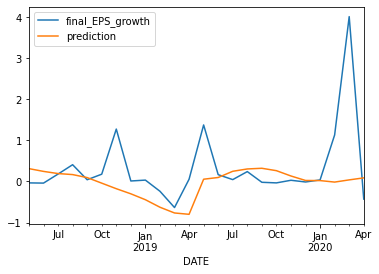

In [103]:
plot.plot()

In [104]:
yhat_1 = k_n_regressor.predict(test_X_1)
yhat_2 = k_n_regressor.predict(test_X_2)

<AxesSubplot:xlabel='DATE'>

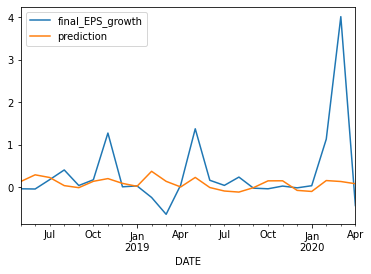

In [105]:
k_n_regressor = np.concatenate([yhat_1, yhat_2], axis=1)
plot = test_data.loc[:,['DATE','final_EPS_growth']].set_index('DATE')
plot['prediction'] = k_n_regressor[0]
plot.plot()

In [106]:
yhat_1 = tree_regressor.predict(test_X_1)
yhat_2 = tree_regressor.predict(test_X_2)

<AxesSubplot:xlabel='DATE'>

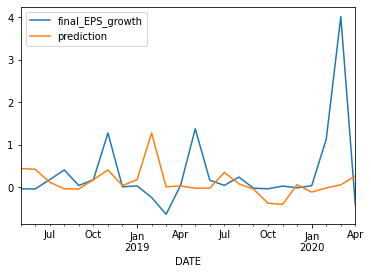

In [107]:
tree_reg_yhat = np.concatenate([yhat_1, yhat_2], axis=1)
plot = test_data.loc[:,['DATE','final_EPS_growth']].set_index('DATE')
plot['prediction'] = tree_reg_yhat[0]
plot.plot()